# Double DQN

In this notebook, we will implement Deep Q-Learning Reinforcement learning algorithm for Lunar Lander Environment.

## Lunar Lander

This environment is a classic rocket trajectory optimization problem. The landing pad is always at coordinates (0,0). The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

There are four discrete actions available:<br>
- 0: do nothing<br>
- 1: fire left orientation engine<br>
- 2: fire main engine<br>
- 3: fire right orientation engine<br>

After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.

- is increased/decreased the slower/faster the lander is moving.

- is decreased the more the lander is tilted (angle not horizontal).

- is increased by 10 points for each leg that is in contact with the ground.

- is decreased by 0.03 points each frame a side engine is firing.

- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.


You can read more the LunarLander environment [here](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

![LunarLander](https://gymnasium.farama.org/_images/lunar_lander.gif)

## Deep Q-Learning

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

But this is not scalable. Must compute $Q(s,a)$ for every state-action pair. If state is e.g. current game state pixels, computationally infeasible to compute for entire state space! But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}



### Double Deep Q-Learning

We will implement Double Deep Q-Learning here. Double Deep Q-Learning is used to reduce the maximaztion bias in Q-Learning. This entails separate action selection and action evaluation in the target value.

- Use the current network to select the max action for the next state
and then use the target network to get the target Q-value for that
action.




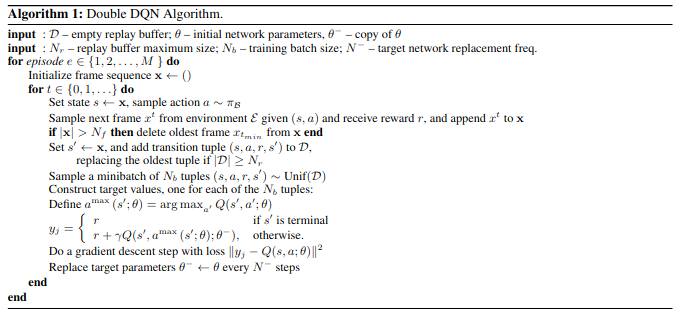

[Image Source](https://leejungi.github.io/posts/Dueling-DQN/)

In [ ]:
!pip install -q swig
!pip install -q gym[box2d]

  Preparing metadata (setup.py) ... done


In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
# Create the environment
env = gym.make("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Experience Replay

Learning from batches of consecutive samples is problematic as the sample are correlated and it can create a bad feedback loop if one action is dominated in the samples.

We can address these problems using an experience replay memory. It maintains a record for all the transitions experienced. The agent is then trained by sampling random minibatches from the replay memory.

In [ ]:
# Named tuple representing a single transition in our environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

# Cyclic buffer of bounded size that holds and samples the transitions observed recently
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Q-Network

In [ ]:
# A neural network approximater for Q-Value.
# It takes the state as input and predicts the Q-value for all actions at that state

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)



### Exploration vs Exploitation

Notice that Q-learning only learns about the states and actions it visits. What if an optimal state remains unvisited due to not being explored. The agent should sometimes pick suboptimal actions in order to visit new states and actions. <br>

A simple strategy is to use an $\epsilon$-greedy policy. According to this policy, the agent takes a random action with epsilon probability. The value of epsilon is high at the start of training and low towards the end. So, the agent explores more at the start and then exploit the learned policy more at the end.

### Hyperparameters

In [ ]:
# Here, we will specify the hyperparameters

total_episodes = 3000         # Total training episodes
max_steps = 1500              # Max steps per episode
learning_rate = 1e-3         # Learning rate
gamma = 0.99                 # Discounting rate
batch_size = 128             # Training Batch size
target_update = 5            # Target network update frequency
train_frquency = 1           # Train Q network every train_frquency episodes
train_epochs = 2             # Training epochs during each training cycle

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 0.001            # Exponential decay rate for exploration prob

# Memory buffer
mb_size = 100000

### Training

In [ ]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print('state size:', state_size)
print('action size:', action_size)

observation space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
action space: Discrete(4)
state size: 8
action size: 4


In [ ]:
# Intialize both Q-networks
policy_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)

# policy_net.load_state_dict(torch.load("/content/gdrive/MyDrive/Colab Notebooks/rl_summer_school/models/hw1_policy_net.pt", map_location=torch.device(device)))

# update target network
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# set up the optimizer
optimizer = optim.RMSprop(policy_net.parameters(), lr=learning_rate)

# Initialize the replay buffer
memory = ReplayMemory(mb_size)

In [ ]:
# get action for current state according to the greedy policy
def get_action(state):
  ## First we randomize a number
  exp_exp_tradeoff = random.uniform(0, 1)
  ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
  if exp_exp_tradeoff > epsilon:
    with torch.no_grad():
      action = policy_net(state).max(1)[1].view(1, 1)

  # Else doing a random choice --> exploration
  else:
    action = env.action_space.sample()
    action = torch.tensor([action], device=device).view(1, 1)
  return action

In [ ]:
# List of rewards
rewards = []
avg_rewards = []

for episode in range(1, total_episodes+1):
    # Initialize the environment and state
    state = env.reset()
    state = torch.tensor([state], device=device)
    total_rewards = 0
    for _ in range(max_steps):
        # Select and perform an action
        action = get_action(state)
        next_state, reward, done, _ = env.step(action.item())

        total_rewards += reward

        reward = torch.tensor([reward], device=device)
        done = torch.tensor([int(done)], device=device)
        next_state = torch.tensor([next_state], device=device)

        # Store the transition in memory
        memory.push(state, action, next_state, reward, done)

        # Move to the next state
        state = next_state

        if done:
            break

    # optimize the policy
    if episode % train_frquency == 0 and len(memory) >= batch_size:
      for _ in range(train_epochs):
        # get samples from experience replay memory
        transitions = memory.sample(batch_size)
        # unroll and reroll to get them in proper format
        batch = Transition(*zip(*transitions))

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        next_state_batch = torch.cat(batch.next_state)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.cat(batch.done)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken
        state_action_values = policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states and get the max q values.
        with torch.no_grad():
          q_policy_network = policy_net(next_state_batch)
          next_idx = torch.unsqueeze(q_policy_network.max(1)[1].detach(), 1)
          q_target_network = target_net(next_state_batch)
          next_state_values = torch.take_along_dim(q_target_network.detach(), next_idx, 1)
          next_state_values = torch.squeeze(next_state_values.reshape(1,batch_size))

          # next_state_values = target_net(next_state_batch).max(1)[0].detach()

        # Compute the target Q values
        target_q_values = (next_state_values * (1-done_batch) * gamma) + reward_batch

        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values, target_q_values.unsqueeze(1))

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    # Update the target network
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    rewards.append(total_rewards)
    avg_rewards.append(sum(rewards)/episode)
    if total_rewards>=200:
      print(f"Episode {episode}: Reward = {total_rewards}, Epsilon = {epsilon},\t Success!")
    else:
      print(f"Episode {episode}: Reward = {total_rewards}, Epsilon = {epsilon}")

Episode 1: Reward = -270.0173694643915, Epsilon = 0.9990104948350412
Episode 2: Reward = -438.36697431757716, Epsilon = 0.9980219786806598
Episode 3: Reward = -247.714198140905, Epsilon = 0.9970344505483393
Episode 4: Reward = -104.30267393119277, Epsilon = 0.9960479094505515
Episode 5: Reward = -108.64803395338842, Epsilon = 0.9950623544007555
Episode 6: Reward = -399.03229812333035, Epsilon = 0.9940777844133959
Episode 7: Reward = -88.48499462588599, Epsilon = 0.9930941985039028
Episode 8: Reward = -364.99872382158384, Epsilon = 0.99211159568869
Episode 9: Reward = -168.71996163233138, Epsilon = 0.9911299749851548
Episode 10: Reward = -526.8680123633621, Epsilon = 0.9901493354116764
Episode 11: Reward = -257.64065125349197, Epsilon = 0.9891696759876151
Episode 12: Reward = -452.3665825250215, Epsilon = 0.9881909957333113
Episode 13: Reward = -453.0980797755851, Epsilon = 0.9872132936700847
Episode 14: Reward = -146.67122247121546, Epsilon = 0.9862365688202333
Episode 15: Reward = -81

In [ ]:
torch.save(policy_net.state_dict(), "/content/gdrive/MyDrive/Colab Notebooks/rl_summer_school/models/hw1_policy_net.pt")

Mounted at /content/gdrive/


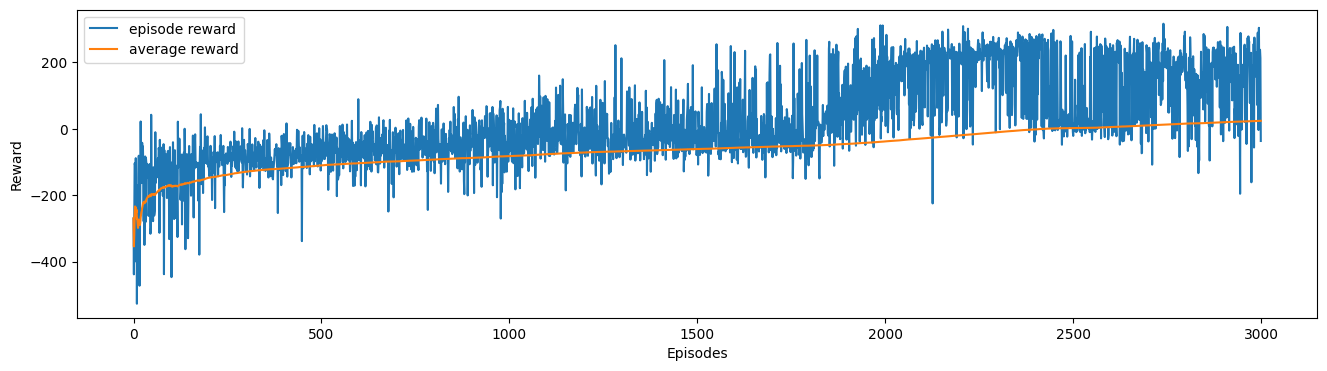

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(rewards, label='episode reward')
plt.plot(avg_rewards, label='average reward')
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()

### Visualization

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    state = torch.tensor([state], device=device)
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action =  get_action(state) # code here
        next_state, reward, done, info = env.step(action.item())
        next_state = torch.tensor([next_state], device=device)
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

show_video_of_model("LunarLander-v2")
show_video("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
